# Recurrent Neural Networks: Example 1 - Clothing Sales Dataset

In this noteboook a real time series dataset is used to build a model and forecast future values.

The dataset was downloaded from the FRED website with data on **Retail Sales: Clothing and Clothing Accessory Stores (Not Seasonally Adjusted)**:

[https://fred.stlouisfed.org/series/RSCCASN](https://fred.stlouisfed.org/series/RSCCASN)

Note that the COVID-19 changes the expected course of the data; therefore, I used the CSV from J.M. Portilla's course, which can be found in the `data` folder:

`../../data/RSCCASN.csv`

`git_repositories/data_science_python_tools/data/RSCCASN.csv`

**Important note 1: it makes sense to have date information instead of date strings to fully handle the time series.
Therefore, often date strings need to be converted into datetime type.**

**Important note 2: few comments are added here; to see more detailed notes, look at previous notebook.**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Load and prepare the dataset

In [2]:
# We load the dataset
# We convert the date string to datetime type on the fly
# and be set that column to be the index
# If we have datetime values, we can use
# - parse_dates=True, or
# - infer_datetime_format=True
df = pd.read_csv('./RSCCASN.csv',parse_dates=True,index_col='DATE')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
# We change the name of the column so that it's easier to remember
# Note that it contains sales in millions by day
df.columns = ['Sales']

In [6]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

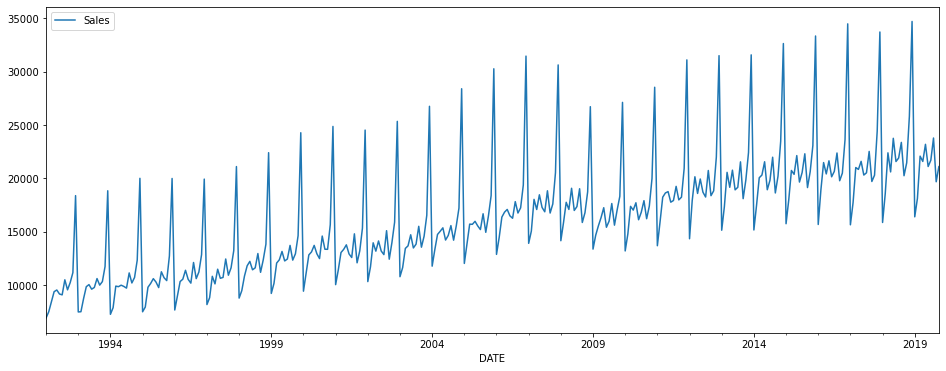

In [7]:
# We can see that a year (12 months or data points) y a cycle or period
# which contains the major trend and a seasonality components.
# Thus, we need to take that time span into consideration for splitting
df.plot(figsize=(16,6))

### Train/Test Split

In [68]:
df.shape

(334, 1)

In [8]:
# Due to the observation above,
# we split in the last 1.5 years = 18 months
len(df)

334

In [9]:
test_size = 18
test_ind = len(df) - test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [11]:
# Now, we need to scale our data
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler()

In [14]:
scaled_train = scaler.transform(train)

In [15]:
scaled_test = scaler.transform(test)

### Generator

In [16]:
# Time series generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# The length of the input series must be smaller than the length of the test split
# if we do early-stopping validation
length = 12
batch_size = 1

In [18]:
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [19]:
# We check the first (X,y) pair of the generator
X,y = generator[0]

In [20]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [69]:
y

array([[0.02047633]])

In [71]:
X.shape

(1, 12, 1)

In [72]:
y.shape

(1, 1)

## 2. Create the Model

In [22]:
from tensorflow.keras.models import Sequential

In [23]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [38]:
n_features = 1
model = Sequential()
#model.add(SimpleRNN(units=100, input_shape=(length,n_features)))
# We explicitly use the ReLu activation
model.add(LSTM(units=100, activation='relu', input_shape=(length,n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

### Early Stopping

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [43]:
# We need to create a validation generator
# The length is the same as before,
# taking into account that it must be shorter than the length of the validation split
validation_generator = TimeseriesGenerator(scaled_test,
                                          scaled_test,
                                          length=length,
                                          batch_size=1)

### Train

In [44]:
# We train with an early stop callback
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 45s 148ms/step - loss: 0.0229 - val_loss: 0.0115
Epoch 2/20
304/304 [==============================] - 43s 143ms/step - loss: 0.0141 - val_loss: 0.0163
Epoch 3/20
304/304 [==============================] - 43s 142ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 4/20
304/304 [==============================] - 43s 143ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 5/20
304/304 [==============================] - 45s 147ms/step - loss: 0.0021 - val_loss: 0.0088
Epoch 6/20
304/304 [==============================] - 46s 151ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 7/20
304/304 [==============================] - 45s 148ms/step - loss: 0.0020 - val_loss: 0.0229
Epoch 8/20
304/304 [==============================] - 45s 147ms/step - loss: 0.0016 - val_loss: 3.5863e-04
Epoch 9/20
304/304 [==============================] - 46s 150ms/step - loss: 0.0013 - val_loss: 2.3015e-04
Epoch 10/20
304/304 [==============================] - 45s 148ms/

In [45]:
# We get the loss values and plot them
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

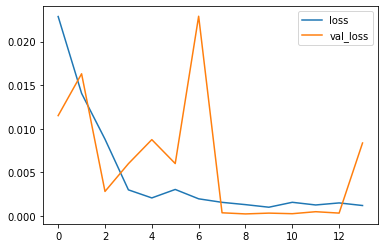

In [46]:
losses.plot()

## 3. Forecasting

### Test Split

In [53]:
# We forecast one by one all the values in the test split
# For that, the batch previous to the test split is taken
# a prediction done for it, and then,
# the batch is moved in time to contain predicted values
test_predictions = []
current_batch = scaled_train[-length:].reshape((1,length,n_features))
for i in range(len(test)):
    predicted = model.predict(current_batch)[0]
    test_predictions.append(predicted)
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [54]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[23775.40398979],
       [22608.45277643],
       [22867.27964211],
       [24679.62425518],
       [22170.31229734],
       [22789.38515568],
       [26455.11649847],
       [35173.82374096],
       [18432.68788648],
       [21026.26678467],
       [24523.43141174],
       [22989.72794914],
       [25881.30177164],
       [24761.26193237],
       [25047.0217123 ],
       [26688.60458946],
       [24393.41463566],
       [25075.54548264]])

In [55]:
test['LSTM Predictions'] = true_predictions

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

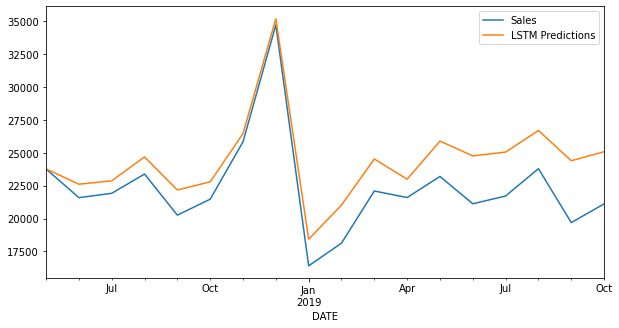

In [56]:
test.plot(figsize=(10,5))

In [57]:
# Compute the RMSE
from sklearn.metrics import mean_squared_error

In [58]:
np.sqrt(mean_squared_error(test['Sales'],test['LSTM Predictions']))

2445.25754206444

### New Timestamps = Forecasting into the Unkown Future

Now, we re-define the same model and re-train it with the full dataset.
We cannot use early-stopping now, because we're training with the complete dataset;
instead, we choose the epochs wwe would have had if patience would've been 0.
After the training, we predict/extrapolate the sales values into the future.

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
full_scaler = MinMaxScaler()

In [61]:
scaled_full_data = full_scaler.fit_transform(df)

In [62]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [63]:
# We take the same parameters for the generator,
# but now the complete dataset is used
length = 12
batch_size = 1
generator = TimeseriesGenerator(data=scaled_full_data,
                                targets=scaled_full_data,
                                length=length,
                                batch_size=batch_size)

In [64]:
# We copy/create our model with the LSTM units
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [65]:
# Model definition: same model as before
n_features = 1
model = Sequential()
model.add(LSTM(units=100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam',loss='mse')

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [67]:
# We train it, this time without early stopping;
# instead we train the number of epochs before the early stop before
model.fit_generator(generator,
                    epochs=9)

Epoch 1/9
322/322 [==============================] - 44s 136ms/step - loss: 0.0237
Epoch 2/9
322/322 [==============================] - 44s 136ms/step - loss: 0.0166
Epoch 3/9
322/322 [==============================] - 44s 138ms/step - loss: 0.0104
Epoch 4/9
322/322 [==============================] - 45s 141ms/step - loss: 0.0043
Epoch 5/9
322/322 [==============================] - 47s 147ms/step - loss: 0.0027
Epoch 6/9
322/322 [==============================] - 49s 151ms/step - loss: 0.0018
Epoch 7/9
322/322 [==============================] - 48s 150ms/step - loss: 0.0019
Epoch 8/9
322/322 [==============================] - 50s 154ms/step - loss: 0.0018
Epoch 9/9
322/322 [==============================] - 49s 152ms/step - loss: 0.0015


In [164]:
# After training, we forecast into the future the range we want
forecast = []
periods_into_future = 24
current_batch = scaled_full_data[-length:].reshape((1,length,n_features))
for i in range(periods_into_future):
    predicted = model.predict(current_batch)[0]
    forecast.append(predicted)
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [165]:
# We inverse the scaling
forecast = scaler.inverse_transform(forecast)

In [166]:
# We check the last period or datapoint timestamp/datetime-index
# The forecasting starts right the next timestamp
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [176]:
# Since we finish on 2019-10-01 with stapsize of 1 month in our full dataset
# we take the next day as start day and the frequency tring 'MS' for monthly data
# More on freq strings: google("pandas frequency strings")
# https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags
forecast_index = pd.date_range(start='2019-11-01',
                               periods=periods_into_future,
                               freq='MS')

In [177]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [174]:
# Check lengths
print(len(forecast),len(forecast_index))

24 24


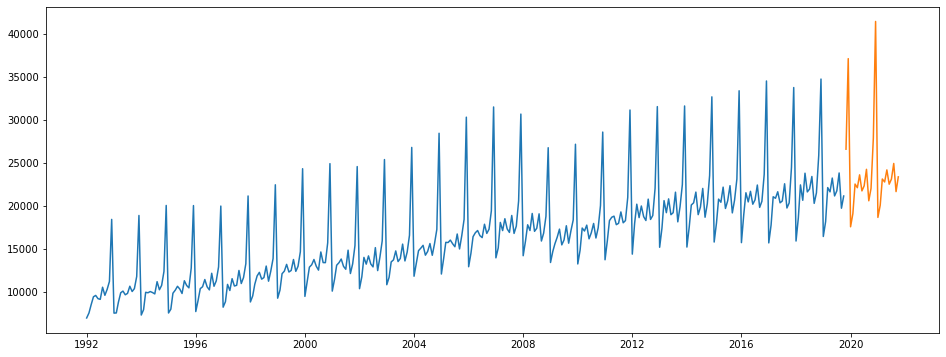

In [175]:
# Now we plot it
plt.figure(figsize=(16,6))
plt.plot(df.index,df['Sales'])
plt.plot(forecast_index,forecast)

In [179]:
# We can also create a dataframe
forecast_df = pd.DataFrame(forecast,index=forecast_index)
forecast_df.columns = ['Sales']

(576.0, 613.0)

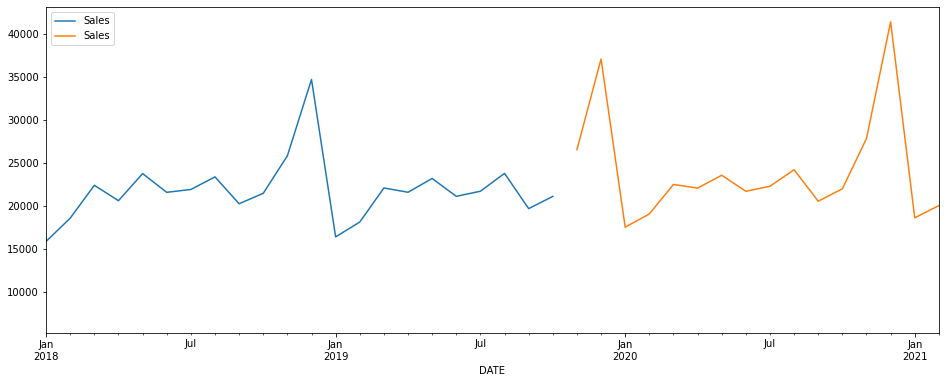

In [189]:
ax = df.plot(figsize=(16,6))
forecast_df.plot(ax=ax)
# We can zooom in
plt.xlim('2018-01-01','2021-02-01')